### Import the GitHub Project

In [84]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 257 (delta 53), reused 38 (delta 14), pack-reused 164
Receiving objects: 100% (257/257), 36.10 MiB | 41.39 MiB/s, done.
Resolving deltas: 100% (142/142), done.


### Install Dependencies
---
- pytorch (1.12.1)
- torchvision (0.13.1)
---
- pytorch3d
---
- SMPL
- chumpy

In [2]:
import os
import sys

In [3]:
# install torch
try:
    import torch
    if torch.__version__ != "1.12.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# install torchvision
try:
    import torchvision
    if torchvision.__version__ != "0.13.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# install pytorch3d
import torch, torchvision

try:
    import pytorch3d
except ModuleNotFoundError:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install pytorch3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=747cb0e049ccdb535f1bd1b9e79e3255f6c064b3ed91c959d914e977bc8b5b4c
  Stored in directory: /root/.cache/pip/wheels/15/6e/e3/602889ca9c5c55020f8d205066445ac5b1b96df59f75170ca0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=8587392a55802e56bd4a7cece1397451665d8ba612d5e59a289ea9de2d9078b7
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu113_pyt1121/download.html
     |████████████████████████████████| 47.2 MB 2.6 MB/s 


In [6]:
# install SMPL dependencies
!pip install smplpytorch
!pip install chumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.8 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58286 sha256=18fb2e8dfad3399352bec15983963f8614b7bd1b8c2af8825343407c857b1c7c
  Stored in directory: /root/.cache/pip/wheels/d9/a2/b8/b8aeeeaeb01b5002085156add1aed832f2fb03e79d0f22dfed
Successfully built chumpy


In [7]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-bugqhi2f
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-bugqhi2f
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=1b20afdc5fede8ecc2b3a6ac3eb260287b3ab6d7329099f5c4ed06731a869d19
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyzh4erm/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


### GPU

In [8]:
torch.cuda.is_available()

True

In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [10]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

### Local Imports 

In [97]:
from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipmodel import CLIPmodel

import clip

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### SMPL

In [13]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(faces):
  nfaces = len(faces[0])
  texture = txfactory.from_facecolor(nfaces=nfaces, facecolor=(0.5, 0.5, 0.5))
  return texture
# pose and shape initalization
pose_vect = torch.zeros(1, 72, device=dev) # theta
shape_vect = torch.zeros(1, 10, device=dev) # beta
# create the smpl model
smpl_model = SMPLwrapper(model=None, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
mesh = smpl_model.mesh(theta=pose_vect, beta=shape_vect)

### Differentiable Renderer

In [137]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# create a camera using the cameras factory
camera = camsfactory.fov_persp_scs(coords=(2.25, 0, 0), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=camera)
# render the textured mesh generated by SMPL
image = renderer.render(mesh)

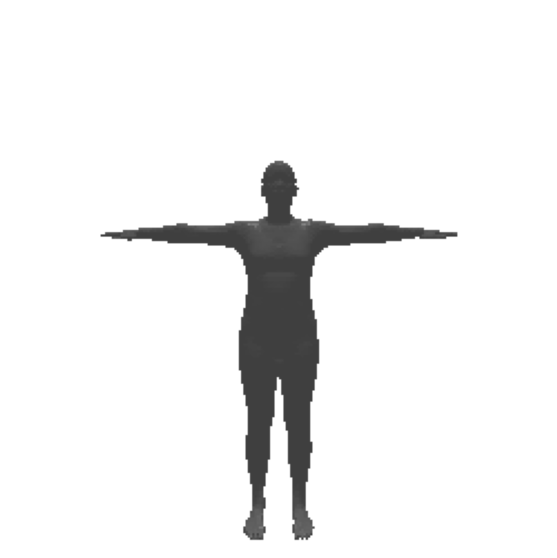

In [15]:
# a quick visualization of the rendered mesh
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.axis("off");

### CLIP

In [98]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### CLIP (with PIL Image input)

If this one runs, the other case below will not

In [237]:
clip_model_pil = CLIPmodel(model="RN50")

In [238]:
prompt = "horse"
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image_pil = torchvision.transforms.ToPILImage()(image)

cosine_distance = clip_model_pil.get_cosine_difference(image_pil, prompt)
cosine_distance

0.8368535339832306

In [239]:
prompt = "human"
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image_pil = torchvision.transforms.ToPILImage()(image)

cosine_distance = clip_model_pil.get_cosine_difference(image_pil, prompt)
cosine_distance

0.8244954198598862

### CLIP (without PIL Image input)

If this one runs, the other case above will not

In [240]:
clip_model_nopil = CLIPmodel(model="RN50")

In [241]:
prompt = "apple"
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image = image[:3,:,:]

cosine_distance = clip_model_nopil.get_cosine_difference(image, prompt)
cosine_distance

0.8286291360855103

In [242]:
prompt = "human"
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image = image[:3,:,:]

cosine_distance = clip_model_nopil.get_cosine_difference(image, prompt)
cosine_distance

0.8218399882316589

### Testing Backpropagation

In [ ]:
from optimization import 